In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_train.csv
/kaggle/input/atis-airlinetravelinformationsystem/atis_intents.csv
/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_test.csv


In [2]:
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score

nltk.download('punkt')
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Путь к файлу CSV
data_path = "/kaggle/input/atis-airlinetravelinformationsystem/atis_intents.csv"
train_data_path = "/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_train.csv"
test_data_path = "/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_test.csv"

# Чтение данных из CSV-файлов
data = pd.read_csv(data_path)
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [4]:
data = data.rename(columns={'atis_flight': 'intent', ' i want to fly from boston at 838 am and arrive in denver at 1110 in the morning': 'text'})
lost_intent = {'intent': 'atis_flight', 'text': 'i want to fly from boston at 838 am and arrive in denver at 1110 in the morning'}
data = pd.concat([data, pd.DataFrame([lost_intent])], ignore_index=True)

In [5]:
# Find classes with only one sample
class_counts = data['intent'].value_counts()
single_sample_classes = class_counts[class_counts == 1].index.tolist()

# Separate single sample classes
single_sample_data = data[data['intent'].isin(single_sample_classes)]
multiple_sample_data = data[~data['intent'].isin(single_sample_classes)]

In [6]:
# train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['intent'])
# Perform stratified split on multiple sample data
train_multiple, test_multiple = train_test_split(multiple_sample_data, test_size=0.2, random_state=42, stratify=multiple_sample_data['intent'])

# Add single sample data to both train and test sets to ensure all classes are present
train = pd.concat([train_multiple, single_sample_data]).reset_index(drop=True)
test = pd.concat([test_multiple, single_sample_data]).reset_index(drop=True)

# Ensure no duplicates in train and test sets
train = train.drop_duplicates().reset_index(drop=True)
test = test.drop_duplicates().reset_index(drop=True)

# unique_values_normalized = train['intent'].value_counts(normalize=True)
# unique_values_normalized_test = test['intent'].value_counts(normalize=True)
# print(unique_values_normalized*100, len(unique_values_normalized), len(unique_values_normalized_test))

In [7]:
# Check for missing classes and ensure all classes are present
train_classes = set(train['intent'])
test_classes = set(test['intent'])
all_classes = set(data['intent'])

# Find missing classes in train and test sets
missing_train_classes = all_classes - train_classes
missing_test_classes = all_classes - test_classes

# Add missing classes examples to train and test sets
if missing_train_classes:
    missing_train_data = data[data['intent'].isin(missing_train_classes)]
    train = pd.concat([train, missing_train_data])
    train = train.drop_duplicates().reset_index(drop=True)

if missing_test_classes:
    missing_test_data = data[data['intent'].isin(missing_test_classes)]
    test = pd.concat([test, missing_test_data])
    test = test.drop_duplicates().reset_index(drop=True)

# Print unique value proportions
unique_values_normalized = train['intent'].value_counts(normalize=True)
unique_values_normalized_test = test['intent'].value_counts(normalize=True)
print(unique_values_normalized * 100, len(unique_values_normalized), len(unique_values_normalized_test)) 

intent
atis_flight                                 73.869079
atis_airfare                                 8.621607
atis_ground_service                          5.082491
atis_airline                                 3.113358
atis_abbreviation                            2.474721
atis_aircraft                                1.676424
atis_flight_time                             1.117616
atis_quantity                                1.091006
atis_distance                                0.425758
atis_flight#atis_airfare                     0.399148
atis_ground_fare                             0.372539
atis_airport                                 0.372539
atis_city                                    0.372539
atis_capacity                                0.345929
atis_flight_no                               0.266099
atis_meal                                    0.133049
atis_restriction                             0.106440
atis_airline#atis_flight_no                  0.053220
atis_ground_service#a

In [8]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
from sklearn import svm
from sklearn.pipeline import Pipeline

In [10]:
# Создание пайплайна
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=lambda x: tokenizer.encode(x, add_special_tokens=True))),
    ('svm', svm.SVC())  
])

# Обучение пайплайна
pipeline.fit(train['text'], train['intent'])

# Прогноз на тестовом наборе
predictions = pipeline.predict(test['text'])

print(balanced_accuracy_score(test['intent'], predictions))
print(precision_recall_fscore_support(test['intent'], predictions, average = 'weighted'))

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.43425676533470503
(0.9331449049937861, 0.9469387755102041, 0.9370972261876515, None)


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


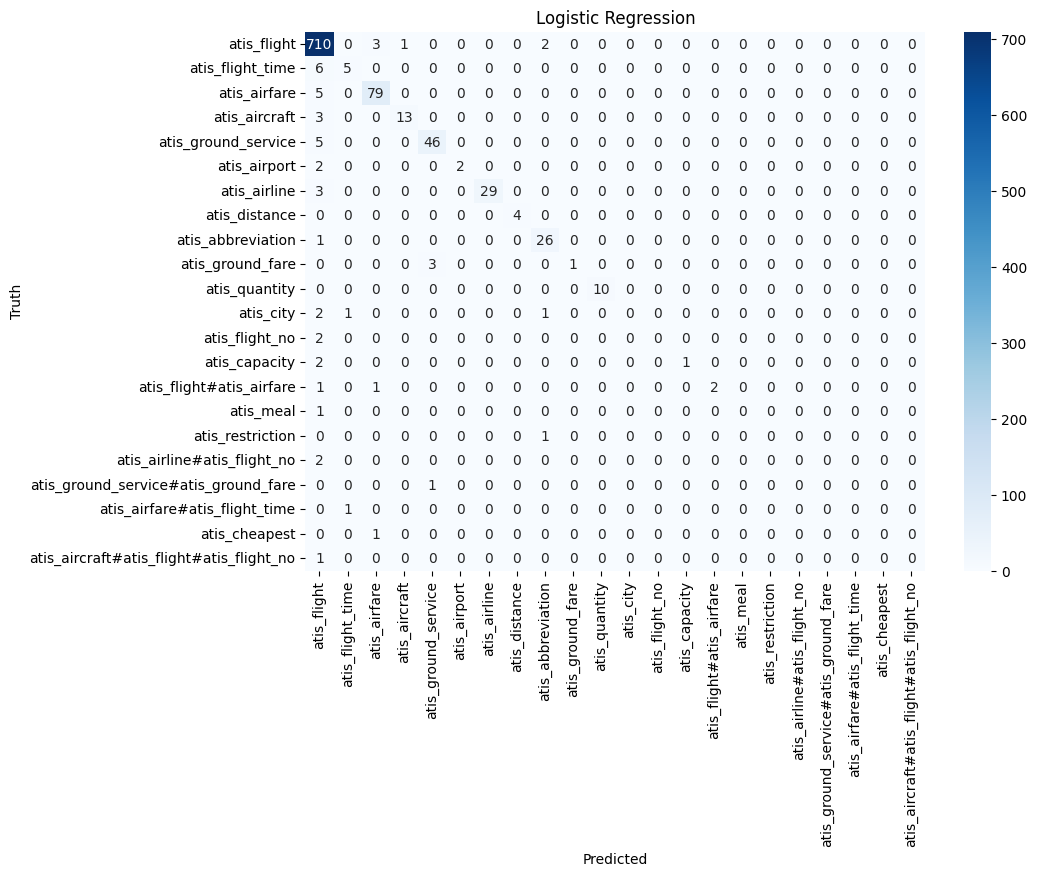

In [11]:
# Построение confusion matrix
labels = data['intent'].unique()  # получите уникальные метки классов
cm = confusion_matrix(test['intent'], predictions, labels=labels)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title(f'Logistic Regression')
plt.show()